In [1]:

from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

import glob


In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 200, 20), 
                 atm_err=0.01, normalize=False, min_exp_time=15., 
                 exptimeCol='visitExposureTime', **kwargs):
        Cols = [m5Col, filterCol, seeingCol, exptimeCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.exptimeCol = exptimeCol
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        self.min_exp_time = min_exp_time
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            if self.min_exp_time is not None:
                good = np.where((dataslice[self.filterCol] == filt) &
                                (dataslice[self.exptimeCol] >= self.min_exp_time))[0]
            else:
                good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2233598 visits
Running:  ['_sims_maf_fbs_1_5_alt_roll_dust_alt_dust_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 51.7381  dipole: lon: 98.32, lat: -84.5903, amp: 23.1901
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2236533 visits
Running:  ['_sims_maf_fbs_1_5_alt_roll_dust_alt_roll_mod2_dust_sdf_0_20_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.1134  dipole: lon: 116.811, lat: -85.2369, amp: 21.6778
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2232460 visits
Running:  ['_sims_maf_fbs_1_5_alt_roll_dust_roll_mod2_dust_sdf_0_20_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.3652  dipole: lon: 107.661, lat: -85.0359, amp: 21.2293
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2056927 visits
Running:  ['_sims_maf_fbs_1_5_baseline_baseline_2snaps_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 53.7545  dipole: lon: 124.479, lat: -83.3815, amp: 18.5723
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2224095 visits
Running:  ['_sims_maf_fbs_1_5_baseline_baseline_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.9513  dipole: lon: 121.825, lat: -82.2703, amp: 18.5573
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2229394 visits
Running:  ['_sims_maf_fbs_1_5_bulge_bulges_bs_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.1937  dipole: lon: 87.8208, lat: -85.7696, amp: 22.0643
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2229125 visits
Running:  ['_sims_maf_fbs_1_5_bulge_bulges_bulge_wfd_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.3026  dipole: lon: 82.0623, lat: -88.0204, amp: 22.207
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2229389 visits
Running:  ['_sims_maf_fbs_1_5_bulge_bulges_cadence_bs_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.2886  dipole: lon: 86.5086, lat: -85.7343, amp: 21.7837
  m

Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2229699 visits
Running:  ['_sims_maf_fbs_1_5_bulge_bulges_cadence_bulge_wfd_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.2647  dipole: lon: 83.7416, lat: -87.8181, amp: 22.1682
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2229448 visits
Running:  ['_sims_maf_fbs_1_5_bulge_bulges_cadence_i_heavy_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.2576  dipole: lon: 77.1449, lat: -87.527, amp: 22.1595
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2229508 visits
Running:  ['_sims_maf_fbs_1_5_bulge_bulges_i_heavy_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 52.3491  dipole: lon: 84.2978, lat: -87.857, amp: 21.9487
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2140016 visits
Running:  ['_sims_maf_fbs_1_5_daily_ddf_daily_ddf_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.1906  dipole: lon: 127.052, lat: -82.6131, amp: 18.4472
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2221048 visits
Running:  ['_sims_maf_fbs_1_5_dcr_dcr_nham1_ug_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7191  dipole: lon: 121.241, lat: -82.2768, amp: 18.339
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2222321 visits
Running:  ['_sims_maf_fbs_1_5_dcr_dcr_nham1_ugr_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.6993  dipole: lon: 119.93, lat: -82.2026, amp: 18.6435
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2223260 visits
Running:  ['_sims_maf_fbs_1_5_dcr_dcr_nham1_ugri_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.6674  dipole: lon: 121.197, lat: -82.3048, amp: 18.4925
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2223585 visits
Running:  ['_sims_maf_fbs_1_5_dcr_dcr_nham2_ug_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.615  dipole: lon: 117.858, lat: -82.4263, amp: 18.7049
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2224613 visits
Running:  ['_sims_maf_fbs_1_5_dcr_dcr_nham2_ugr_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.8364  dipole: lon: 118.666, lat: -81.8155, amp: 18.2073
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'observationStartMJD', 'seeingFwhmGeom', 'filter', 'fiveSigmaDepth', 'fieldRA', 'visitExposureTime'].
Found 2228175 visits
Running:  ['_sims_maf_fbs_1_5_dcr_dcr_nham2_ugri_v1_5_10yrs_L4_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 54.7113  dipole: lon: 118.28, lat: -83.0653, amp: 18.0575
  mono, lon, lat, amp


Plotting complete.


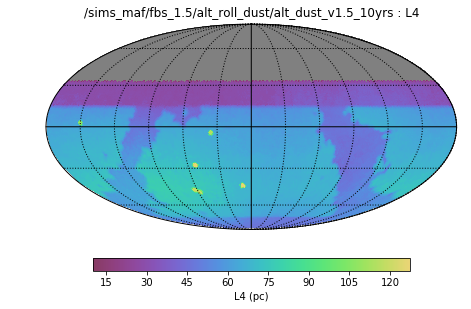

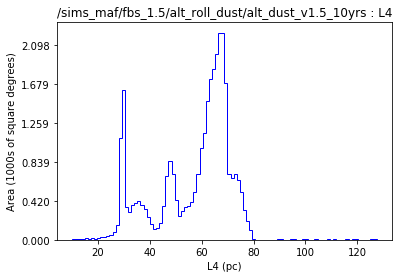

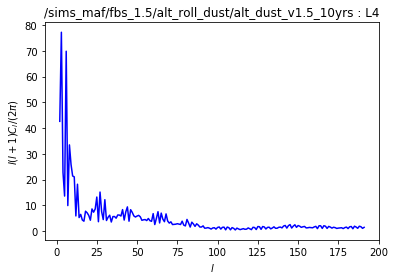

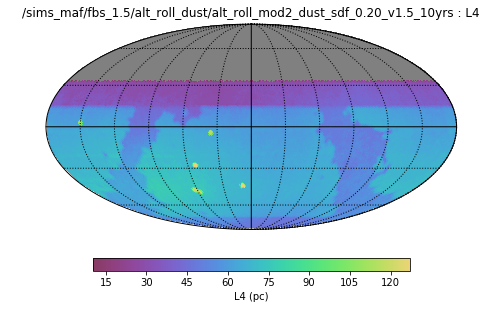

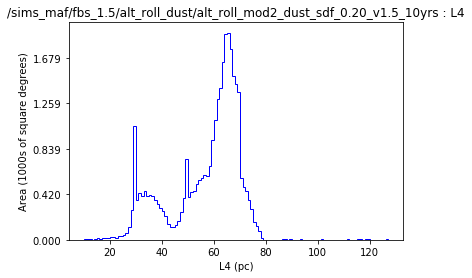

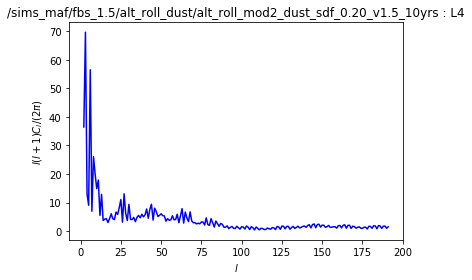

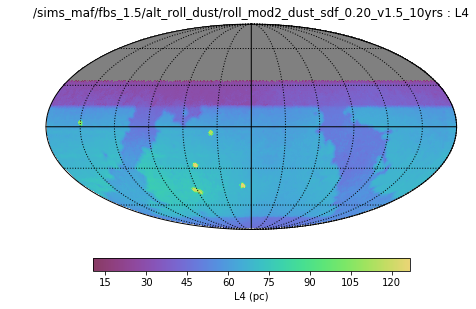

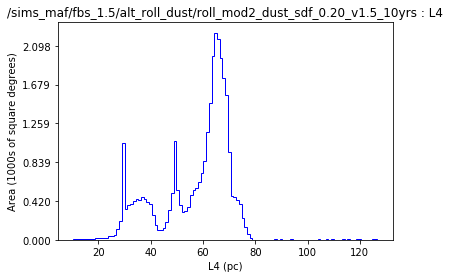

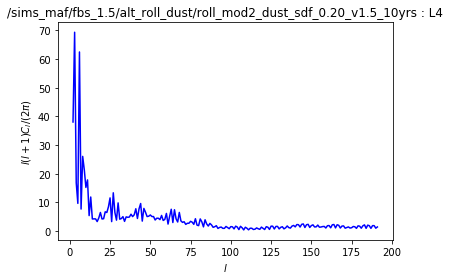

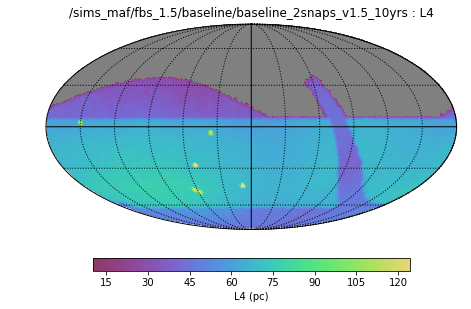

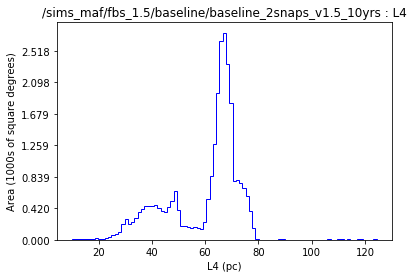

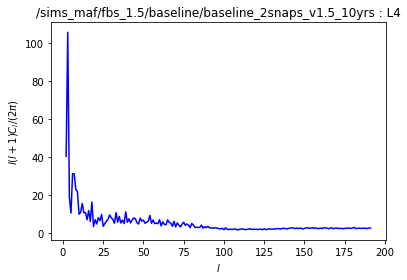

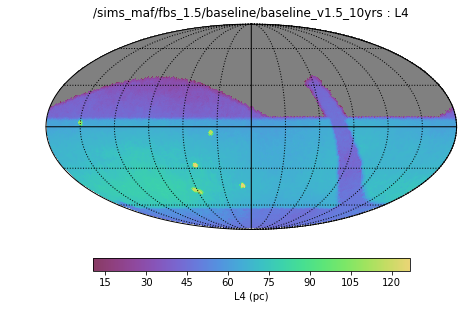

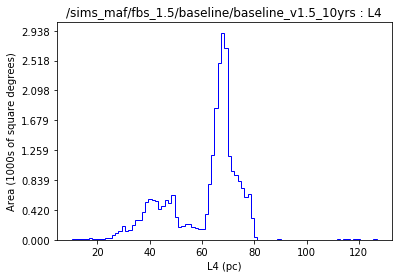

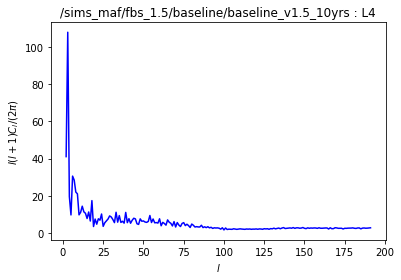

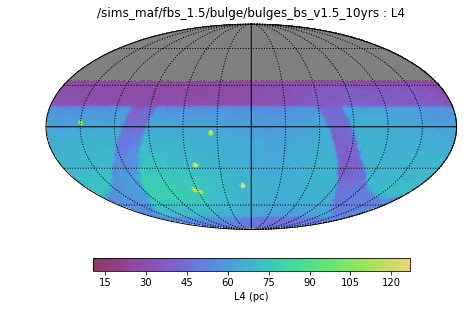

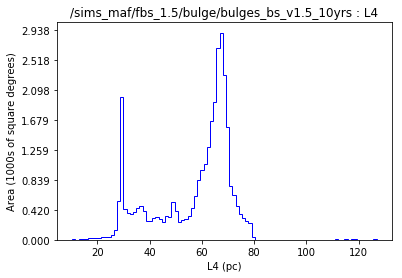

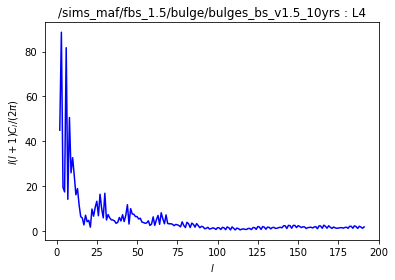

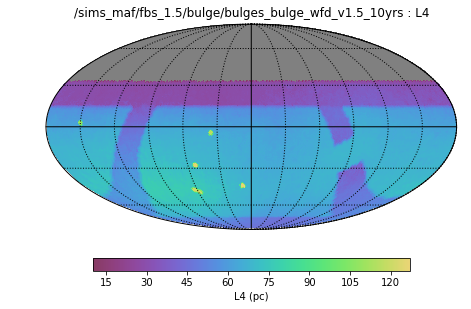

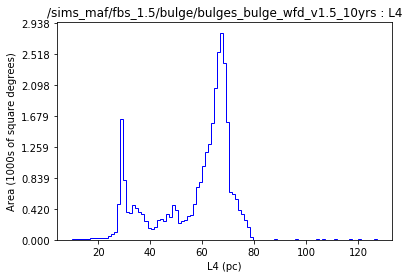

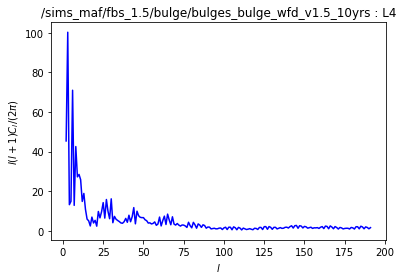

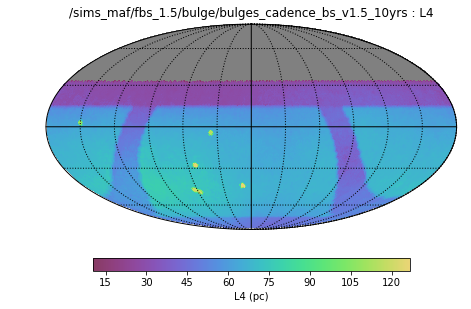

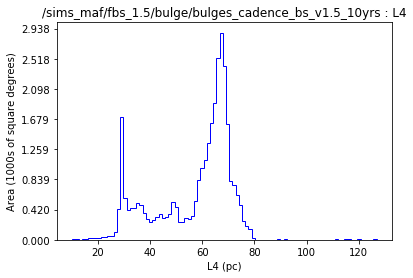

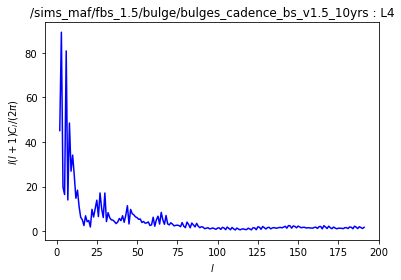

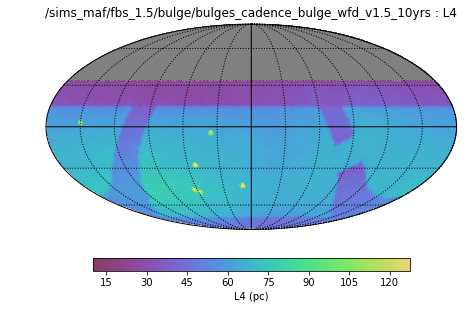

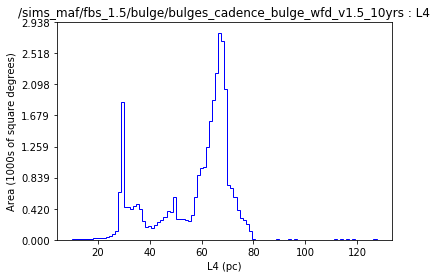

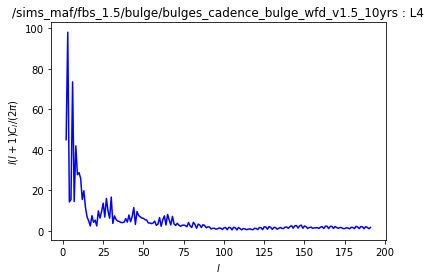

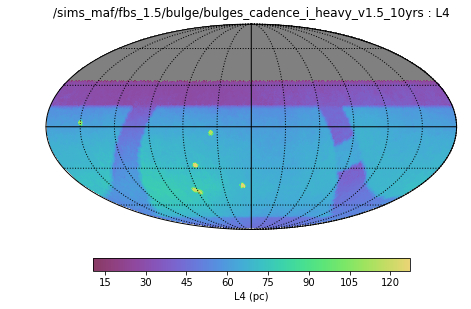

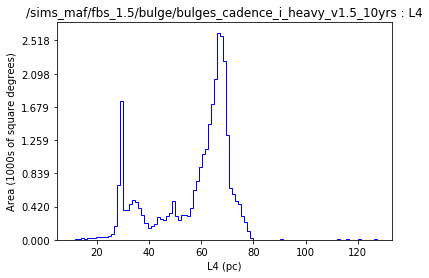

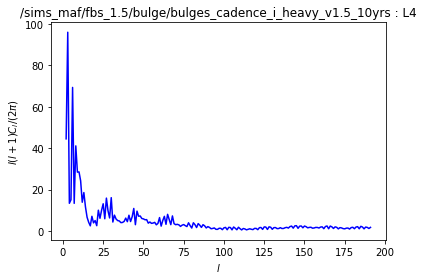

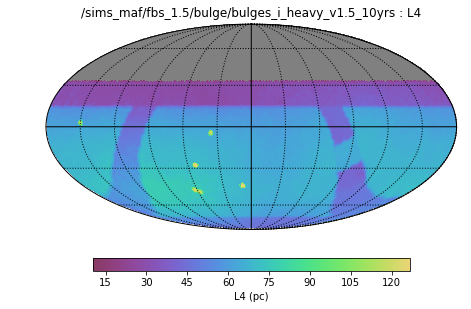

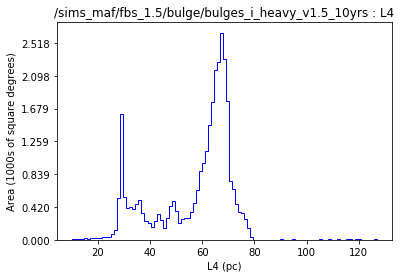

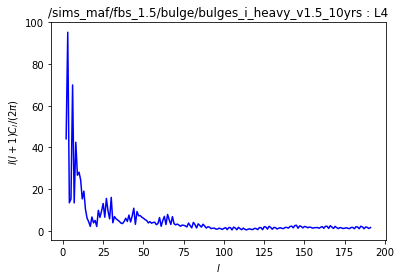

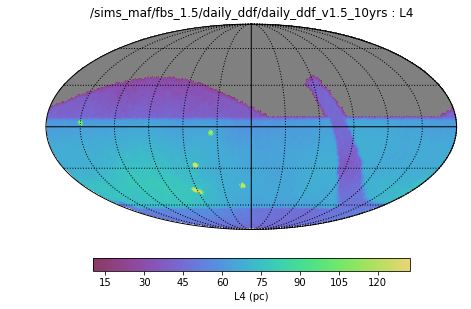

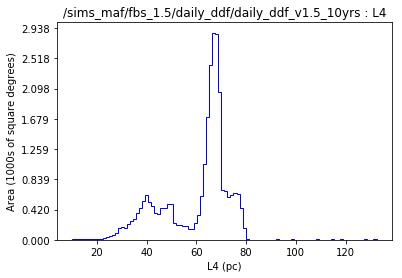

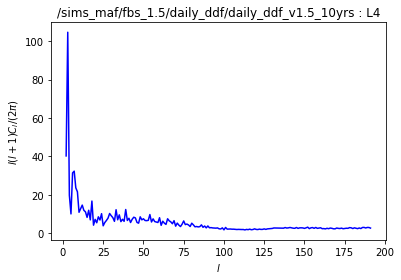

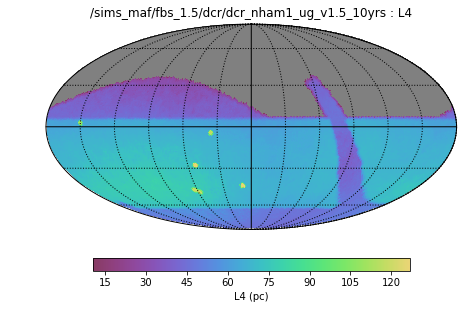

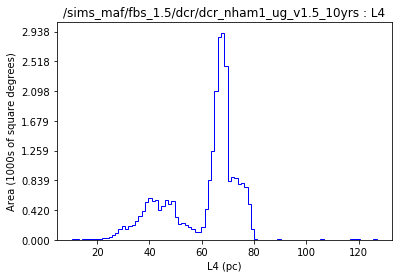

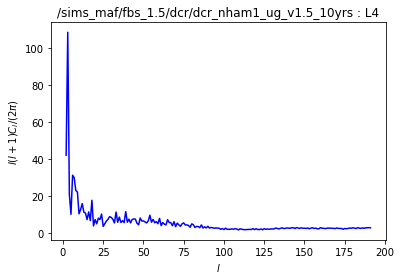

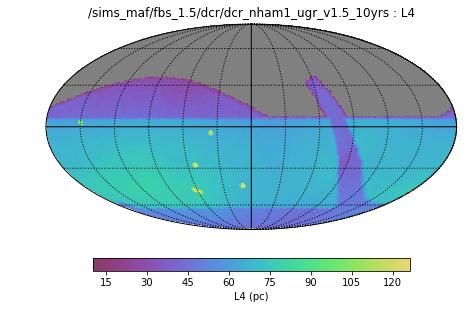

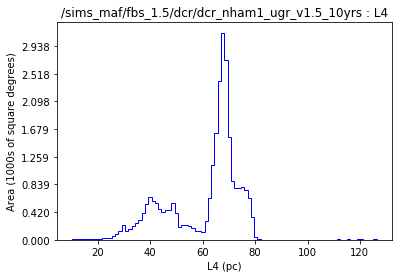

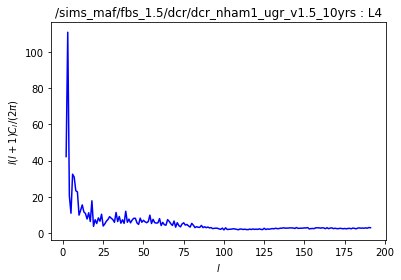

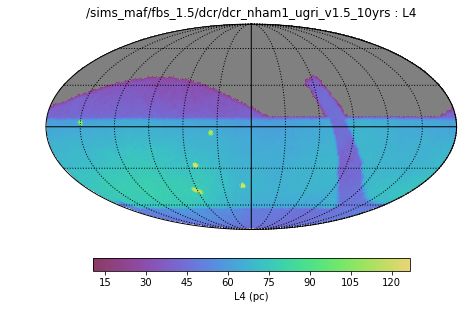

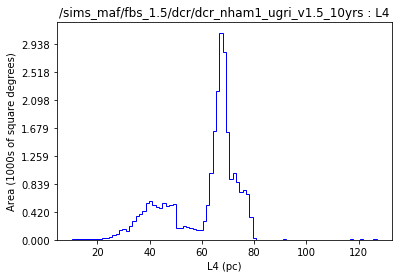

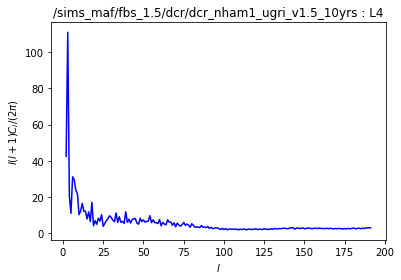

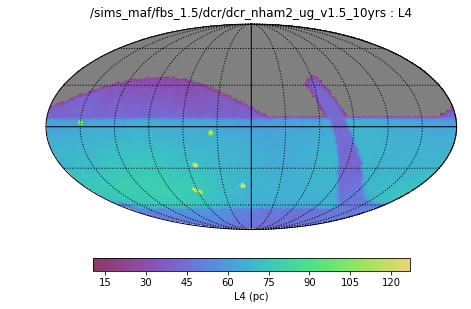

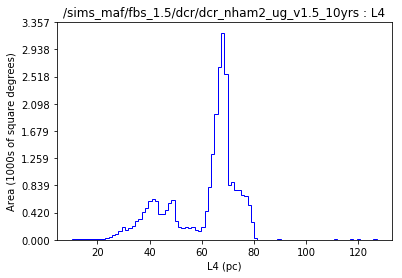

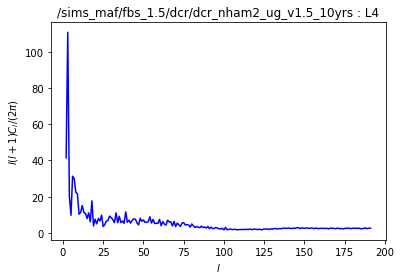

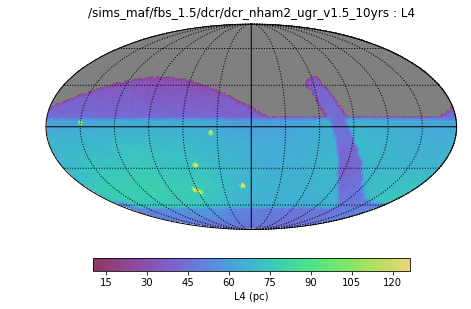

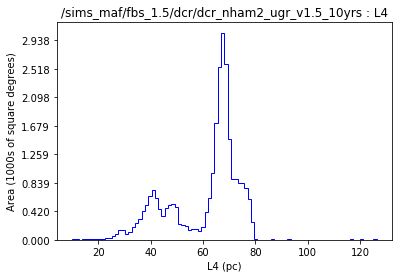

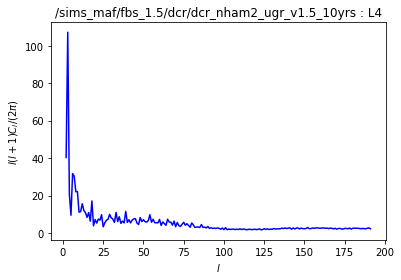

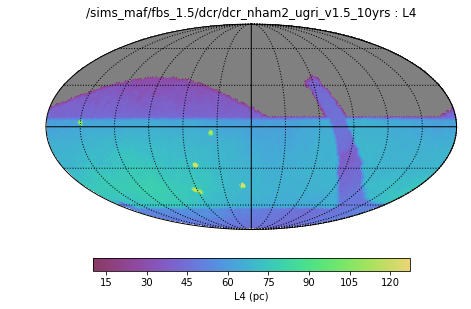

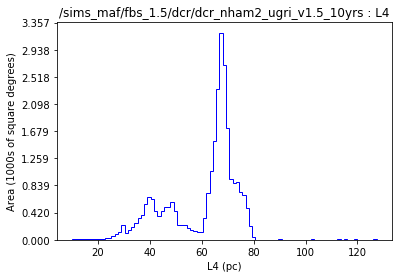

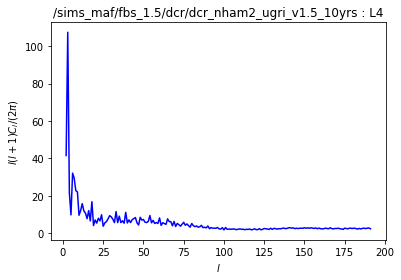

In [4]:
files = glob.glob('/sims_maf/fbs_1.5/[a-e]*/*.db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_1.5/',"L4results/")
    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 18.35, 'z': 16.68, 'y': 15.66}, metricName='L4')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    # add DCR degeneracy check...
    #sql = 'filter="z" or filter="y"'
    #metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
    #bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
    #                                         runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll(closefigs=False)

    results.append(bg)

In [5]:
# Let's see how the total volume changes as we change the footprint
for name, result in zip(files, results):
    key = list(result.bundleDict.keys())[0]
    result.bundleDict[key]
    print(name, result.bundleDict[key].summaryValues)

/sims_maf/fbs_1.5/alt_roll_dust/alt_dust_v1.5_10yrs.db {'VolumeSum': 712209.198266478}
/sims_maf/fbs_1.5/alt_roll_dust/alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db {'VolumeSum': 696702.4234487226}
/sims_maf/fbs_1.5/alt_roll_dust/roll_mod2_dust_sdf_0.20_v1.5_10yrs.db {'VolumeSum': 701565.5240937616}
/sims_maf/fbs_1.5/baseline/baseline_2snaps_v1.5_10yrs.db {'VolumeSum': 681123.4145178796}
/sims_maf/fbs_1.5/baseline/baseline_v1.5_10yrs.db {'VolumeSum': 720261.4620900854}
/sims_maf/fbs_1.5/bulge/bulges_bs_v1.5_10yrs.db {'VolumeSum': 720882.641071992}
/sims_maf/fbs_1.5/bulge/bulges_bulge_wfd_v1.5_10yrs.db {'VolumeSum': 725063.6821005719}
/sims_maf/fbs_1.5/bulge/bulges_cadence_bs_v1.5_10yrs.db {'VolumeSum': 720465.0894895224}
/sims_maf/fbs_1.5/bulge/bulges_cadence_bulge_wfd_v1.5_10yrs.db {'VolumeSum': 723628.3891984168}
/sims_maf/fbs_1.5/bulge/bulges_cadence_i_heavy_v1.5_10yrs.db {'VolumeSum': 721707.2421334151}
/sims_maf/fbs_1.5/bulge/bulges_i_heavy_v1.5_10yrs.db {'VolumeSum': 721932.647819745

In [6]:
print('hi')




hi
